# Single Subject Segmentation Q1K

In [1]:
# import packages
#import q1k_sync_tools as qst
import mne
import mne_bids
#mne.viz.set_browser_backend('qt')
#%matplotlib qt
#pd.options.mode.chained_assignment = None
#import pylossless as ll
import numpy as np
import pandas as pd
#import glob

import matplotlib.pyplot as plt

from pathlib import Path
import shutil
import pylossless as ll

import warnings
warnings.filterwarnings('ignore')


/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set the parameters and read the pylossless data.

In [2]:
project_path = "/home/james/q1k/pilot/q1k-external-pilot/"
pylossless_path = "derivatives/pylossless/"
postproc_path = "derivatives/q1k_postproc/"
task_id_in = "VEP"
task_id_out = "vp"
subject_id = '096'
session_id = '01'

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id_out, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path
)
print(bids_path)

/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-vp_run-1_eeg.edf


In [3]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

# Interpret the annotations and apply the data selections.

In [4]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

Used Annotations descriptions: ['DIN2', 'DIN3', 'dbrk', 'dend', 'fvcr', 'fvct', 'fvsb', 'fvsr', 'sv06', 'sv06_d', 'sv15', 'sv15_d']


Extracting EDF parameters from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-vp_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-vp_run-1_events.tsv.
Reading channel info from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-vp_run-1_channels.tsv.
Reading electrode coords from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-vp_run-1_ica1_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossles

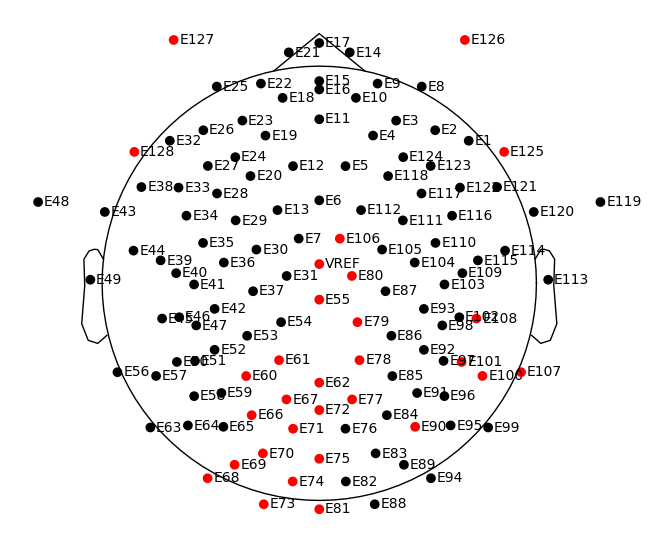

Reading 0 ... 444999  =      0.000 ...   444.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (98 components)
    Zeroing out 21 ICA components
    Projecting back using 99 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.0s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 99 sensor positions
Interpolating 30 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | sub-096_ses-01_task-vp_run-1_eeg.edf, 129 x 445000 (445.0 s), ~438.1 MB, data loaded>

In [5]:
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(bids_path)
bids_path_str=str(bids_path)
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

fig = ll_qcr.plot_sensors(show_names=True)

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(bids_path_str.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=50.0)
ll_qcr = ll_qcr.interpolate_bads()
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

# Segment the data to 'sv06' and 'sv15'

In [6]:
# Relabel condition vars for niceness
eeg_event_dict['sv/audio/disp/sv06'] = eeg_event_dict.pop('sv06')
eeg_event_dict['sv/audio/disp/sv15'] = eeg_event_dict.pop('sv15')

In [7]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(ll_qcr, eeg_events, event_id=eeg_event_dict, tmin=-1, tmax=2.0, on_missing='warn', event_repeated='drop')
epochs = epochs[['sv06', 'sv15']]
display(epochs)
epochs.save(project_path + pylossless_path + postproc_path + 'epoch_fif_files/vp/' + bids_path.basename + '_epochs.fif', overwrite=True)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1323 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


Number of events,120
Events,sv/audio/disp/sv06: 60sv/audio/disp/sv15: 60
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


Using data from preloaded Raw for 120 events and 3001 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 1 events and 3001 original time points ...
Using data from preloaded Raw for 119 events and 3001 original time points ...


In [8]:
evokeds = {'sv06': epochs['sv06'].average(), 'sv15': epochs['sv15'].average()}
mne.write_evokeds(project_path + pylossless_path + postproc_path + 'erp_fif_files/vp/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)

# Plot ERP envelopes and topographies

No projector specified for this dataset. Please consider the method self.add_proj.


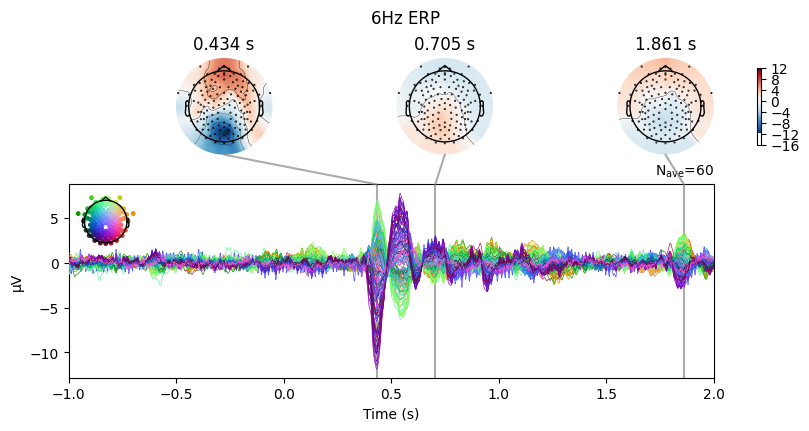

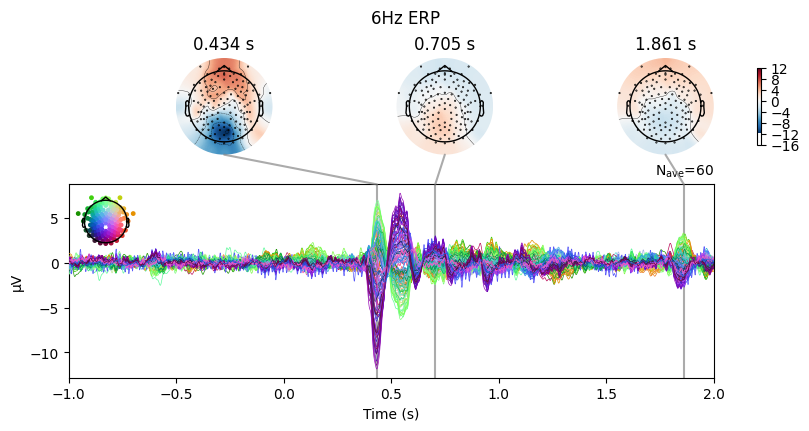

In [9]:
evokeds['sv06'].plot_joint(title='6Hz ERP')

No projector specified for this dataset. Please consider the method self.add_proj.


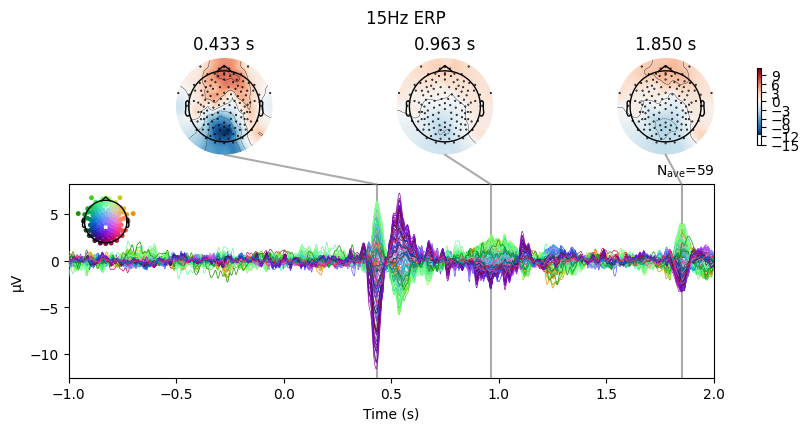

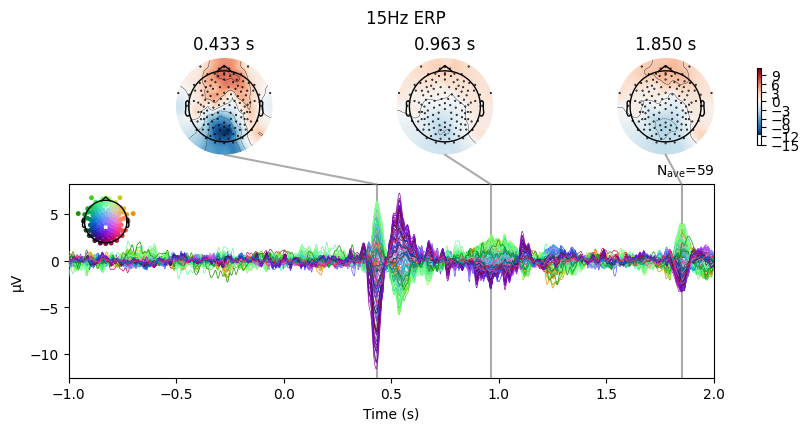

In [10]:
evokeds['sv15'].plot_joint(title='15Hz ERP')

# Plot the ERP overlay

combining channels using "mean"
combining channels using "mean"


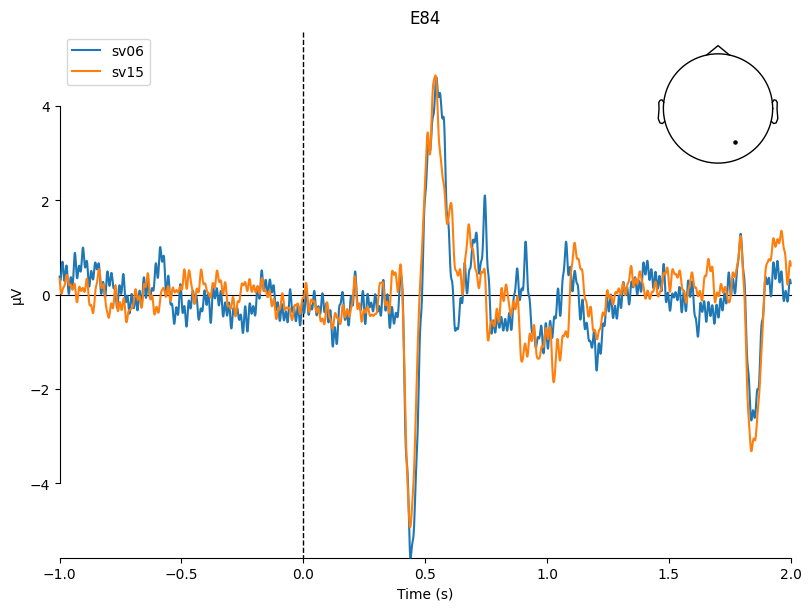

[<Figure size 800x600 with 2 Axes>]

In [11]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['E84'], combine='mean')

In [12]:
#epochs_condition_1 = epochs['sv06']
#epochs_condition_2 = epochs['sv15']
ch_name = 'E84'

decim = 2
freqs = np.arange(3, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

#epochs_chan = epochs.pick_channels([ch_name])


In [13]:
decim = 2
freqs = np.arange(2, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_1, itc_1 = mne.time_frequency.tfr_morlet(
    epochs['sv06'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

pow_2, itc_2 = mne.time_frequency.tfr_morlet(
    epochs['sv15'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

itc_dat_1 = itc_1.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_1 = pow_1.data[0, :, :]  # only 1 channel as 3D matrix

itc_dat_2 = itc_2.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_2 = pow_2.data[0, :, :]  # only 1 channel as 3D matrix

Using data from preloaded Raw for 60 events and 3001 original time points ...
Using data from preloaded Raw for 59 events and 3001 original time points ...


Text(0.5, 0, 'Time (ms)')

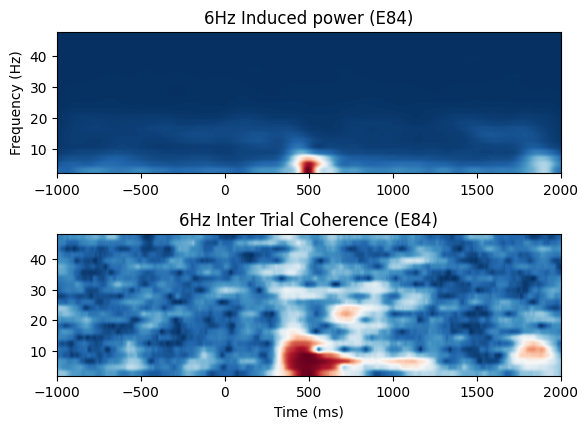

In [14]:
times = 1e3 * epochs['sv06'].times  # change unit to ms

fig1, (ax1t, ax1b) = plt.subplots(2, 1, figsize=(6, 4))
fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax1t.imshow(
    pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1b.imshow(
    itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1t.set_ylabel("Frequency (Hz)")
ax1t.set_title(f"6Hz Induced power ({ch_name})")
ax1b.set_title(f"6Hz Inter Trial Coherence ({ch_name})")
ax1b.set_xlabel("Time (ms)")

Text(0.5, 0, 'Time (ms)')

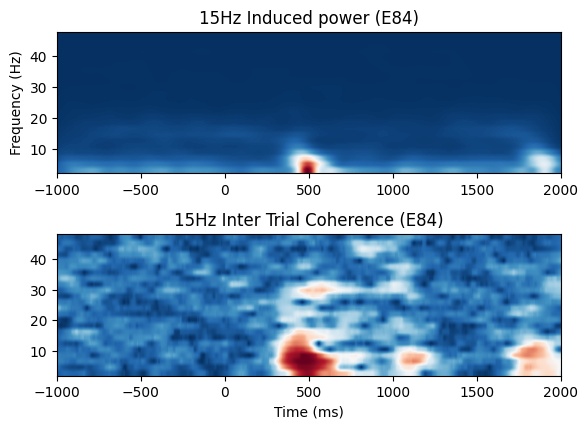

In [15]:
fig2, (ax2t, ax2b) = plt.subplots(2, 1, figsize=(6, 4))
fig2.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax2t.imshow(
    pow_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2b.imshow(
    itc_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2t.set_ylabel("Frequency (Hz)")
ax2t.set_title(f"15Hz Induced power ({ch_name})")
ax2b.set_title(f"15Hz Inter Trial Coherence ({ch_name})")
ax2b.set_xlabel("Time (ms)")


Text(0.5, 0, 'Time (ms)')

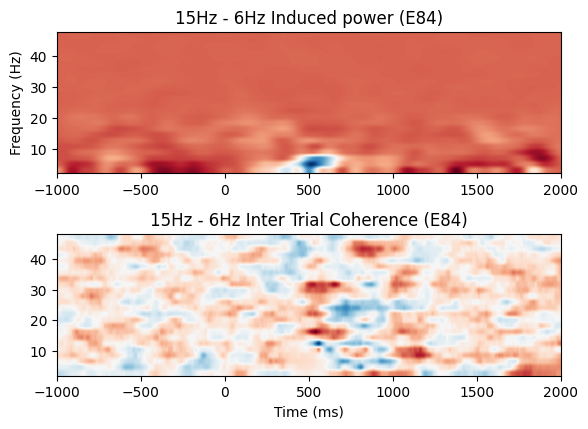

In [16]:
fig3, (ax3t, ax3b) = plt.subplots(2, 1, figsize=(6, 4))
fig3.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax3t.imshow(
    pow_dat_2 - pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3b.imshow(
    itc_dat_2 - itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3t.set_ylabel("Frequency (Hz)")
ax3t.set_title(f"15Hz - 6Hz Induced power ({ch_name})")
ax3b.set_title(f"15Hz - 6Hz Inter Trial Coherence ({ch_name})")
ax3b.set_xlabel("Time (ms)")


In [17]:
!jupyter nbconvert --output {"session_reports/" + bids_path.basename + ".html"} --TagRemovePreprocessor.remove_all_outputs_tags='{"exclude"}' --no-input --to html session_seg_vp.ipynb

[NbConvertApp] Converting notebook session_seg_vp.ipynb to html
[NbConvertApp] Writing 2045127 bytes to session_reports/sub-096_ses-01_task-vp_run-1_eeg.html
